# WGAN-GP - Wasserstein GAN



## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.15.0'

## Loading and preprocessing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [5]:
X_train.shape

(60000, 28, 28, 1)

In [6]:
X_train = (X_train - 127.5) / 127.5

In [7]:
buffer_size = 60000
batch_size = 256

In [8]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

- The same architecture of DCGAN

In [9]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [10]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [11]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.9365398 , -0.8564313 ,  0.2398296 ,  0.7389339 , -1.2891693 ,
        -0.51269674, -0.20823824,  1.5751325 ,  0.1647309 ,  0.92452955,
         0.9048124 , -1.2466428 ,  1.8379495 ,  0.08692577,  0.43039823,
        -0.06129761, -0.7416182 ,  1.5958588 ,  1.6507502 ,  0.3828994 ,
        -0.69537795,  0.40307018,  0.41713524,  0.21171147, -0.09219513,
         0.82648623,  0.20873956,  0.1220054 , -0.6003761 , -0.6831737 ,
         0.30138007,  0.2030213 ,  0.61908543, -1.6573461 ,  1.6934729 ,
        -0.7476618 ,  0.5535656 , -0.6125851 , -0.73026097, -0.3661106 ,
        -0.8263242 ,  0.889702  , -0.24786301, -0.9482717 , -1.6883035 ,
         0.5309028 , -0.46395236, -0.30492872,  1.4907523 ,  0.15170167,
         0.605912  ,  0.30195338,  0.98442847,  0.11525778, -0.27683678,
         0.32389107,  1.4188354 ,  0.3589787 ,  1.8448925 ,  1.2950927 ,
        -0.00224593, -0.23554106, -0.34587285,  1.1668192 , -0.03680347,
 

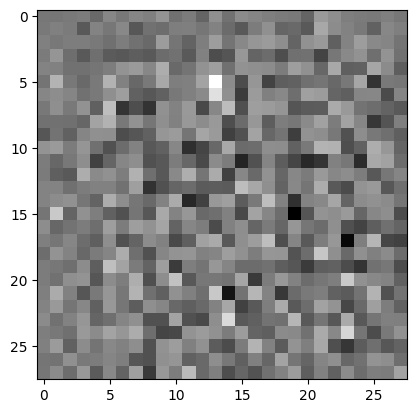

In [12]:
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

## Building the discriminator

- The discriminator is also called as "critic"

In [13]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [14]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [15]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00070138]], dtype=float32)>

In [16]:
tf.sigmoid(-0.00030457)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992383>


## Function to calculate **Wasserstein Loss**

The (*loss*) is the difference between the expected output of the discriminator for authentic images and the expected output of the discriminator for fake images (generated by the generator).

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.


In [17]:
(0.2 + 0.9 + 0.99) / 3

0.6966666666666667

In [18]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6966667>

In [19]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

In [20]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 To use Wasserstein loss, the discriminator must be **1-L** [(1-Lipschitz) continous](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt) - maximum 1.

To use 1-L we need **Gradient Penalty**.

This variation is called **WGAN-GP** (**G**radient **P**enalty)

(More information about Gradient Penalty [this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Steps to calculate gradient penalty:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm. Documentation: - tf.norm: https://www.tensorflow.org/api_docs/python/tf/norm
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

We use [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
3 ** 2

9

In [21]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [22]:
# 0.2 -> 0.02 -> 0.002

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)



## Training and visualizing the results

In [25]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [26]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-1.1741437 ,  0.82349646,  0.02395631, ..., -0.38993907,
         0.8672517 ,  0.5135993 ],
       [-1.6975691 , -0.9228476 ,  0.14033602, ...,  0.18635619,
        -0.40156442, -0.8307419 ],
       [ 0.7366773 , -1.6722796 , -0.5600759 , ...,  0.00732826,
         0.05006492, -1.3621577 ],
       ...,
       [-0.07454427,  1.2597238 , -1.3501768 , ...,  0.7644639 ,
         0.13298772, -0.0109742 ],
       [ 0.69579655, -0.19552138, -0.9349146 , ..., -0.6929946 ,
         1.3095354 , -0.19216168],
       [-1.2846404 , -1.0280979 ,  0.5651421 , ..., -0.9933158 ,
         0.2557803 ,  1.6955848 ]], dtype=float32)>

In [27]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [28]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [29]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

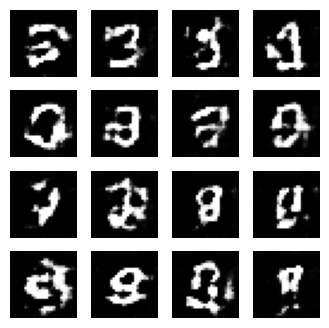

Time taken to process epoch 1 was 70.62362170219421 seconds


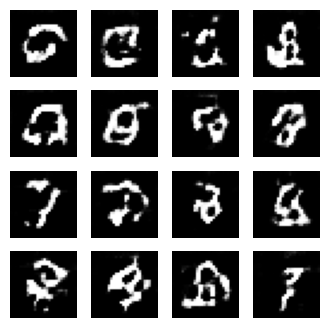

Time taken to process epoch 2 was 60.370548486709595 seconds


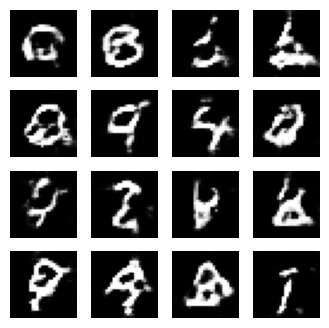

Time taken to process epoch 3 was 82.58312368392944 seconds


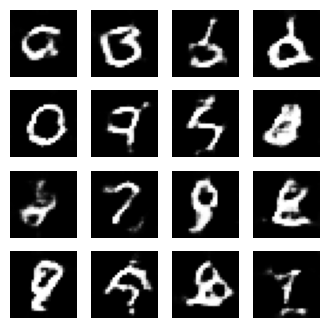

Time taken to process epoch 4 was 82.36172151565552 seconds


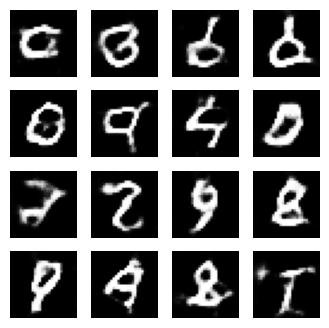

Time taken to process epoch 5 was 60.42302322387695 seconds


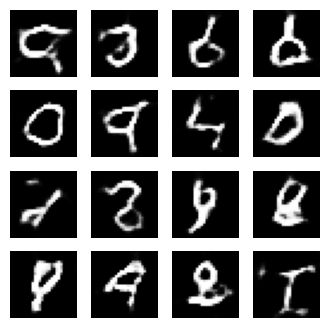

Time taken to process epoch 6 was 60.18390440940857 seconds


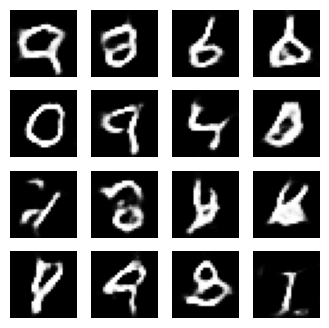

Time taken to process epoch 7 was 60.09556818008423 seconds


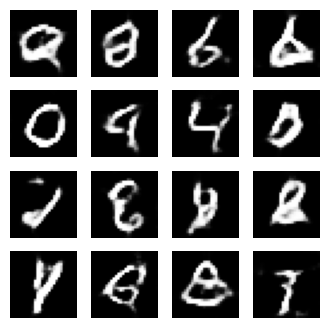

Time taken to process epoch 8 was 60.785484075546265 seconds


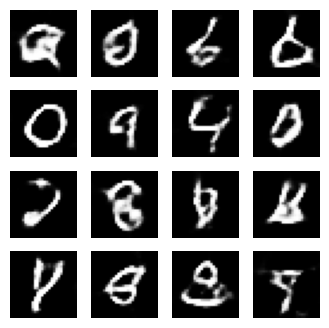

Time taken to process epoch 9 was 60.12186574935913 seconds


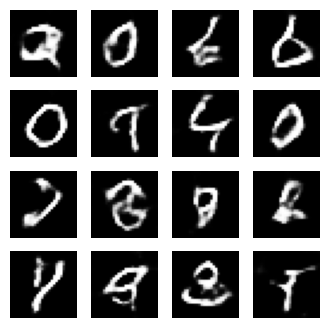

Time taken to process epoch 10 was 60.59825277328491 seconds


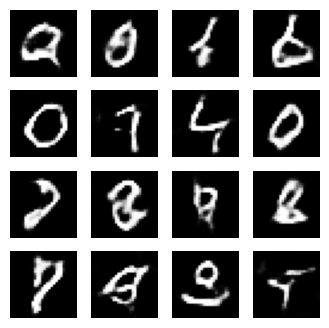

Time taken to process epoch 11 was 59.840965270996094 seconds


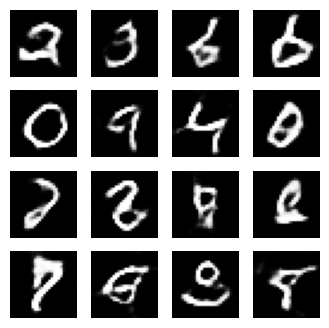

Time taken to process epoch 12 was 60.64602255821228 seconds


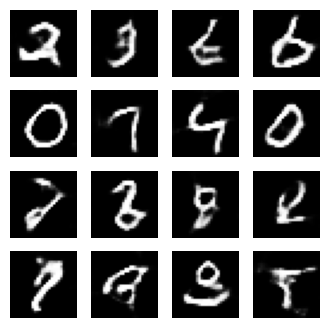

Time taken to process epoch 13 was 59.985079526901245 seconds


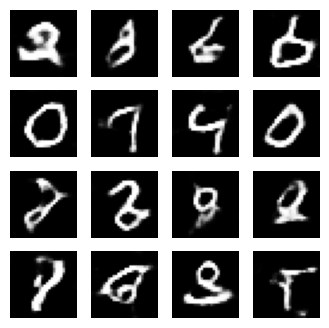

Time taken to process epoch 14 was 82.58785057067871 seconds


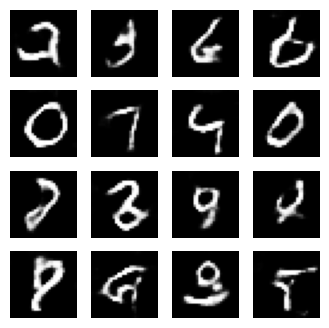

Time taken to process epoch 15 was 60.29615592956543 seconds


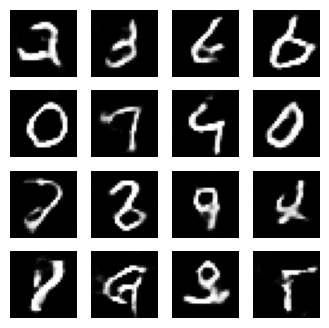

Time taken to process epoch 16 was 60.734726905822754 seconds


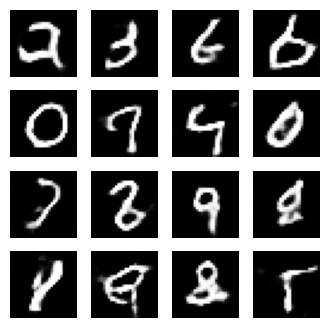

Time taken to process epoch 17 was 82.6383593082428 seconds


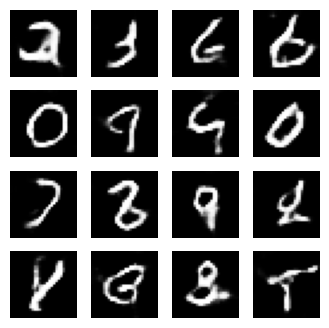

Time taken to process epoch 18 was 82.7315309047699 seconds


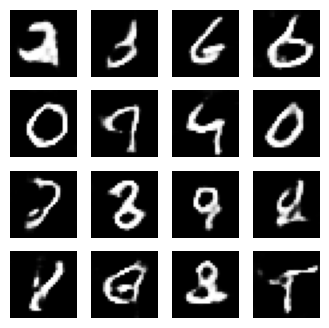

Time taken to process epoch 19 was 60.518572092056274 seconds


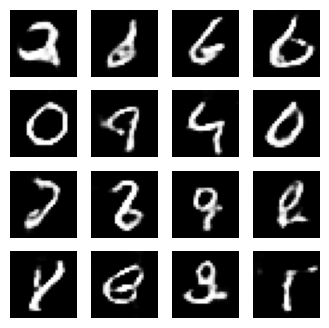

Time taken to process epoch 20 was 60.31934571266174 seconds


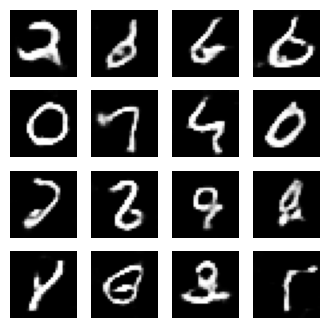

Time taken to process epoch 21 was 60.00166893005371 seconds


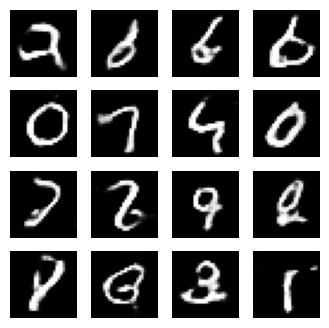

Time taken to process epoch 22 was 60.123616456985474 seconds


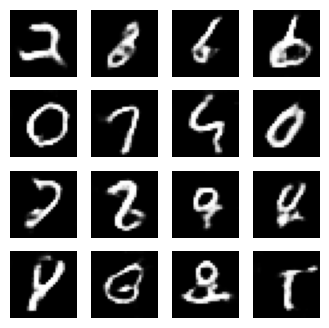

Time taken to process epoch 23 was 59.94585704803467 seconds


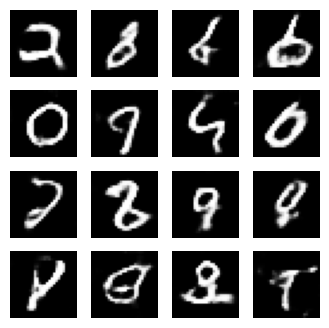

Time taken to process epoch 24 was 60.72547483444214 seconds


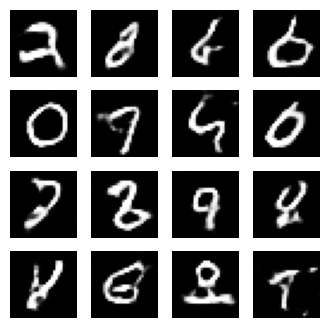

Time taken to process epoch 25 was 82.60578846931458 seconds


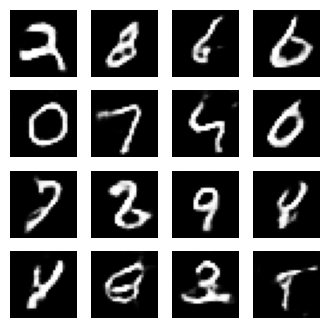

Time taken to process epoch 26 was 82.35350155830383 seconds


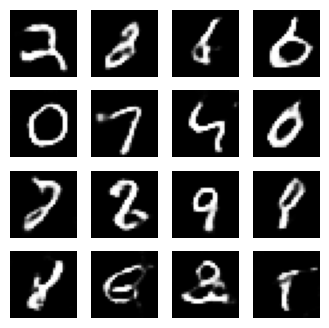

Time taken to process epoch 27 was 61.26964449882507 seconds


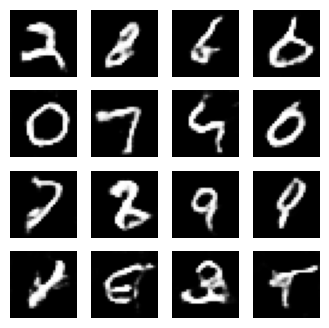

Time taken to process epoch 28 was 59.885244607925415 seconds


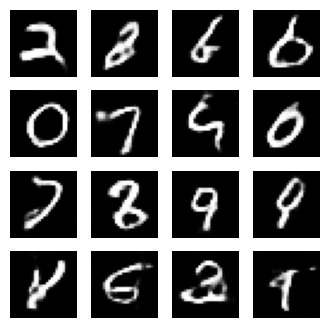

Time taken to process epoch 29 was 60.075279235839844 seconds


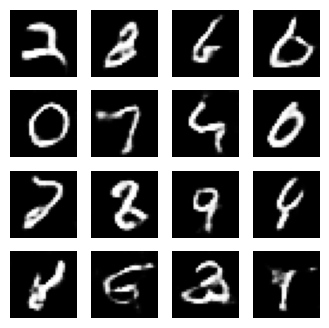

Time taken to process epoch 30 was 60.28547549247742 seconds


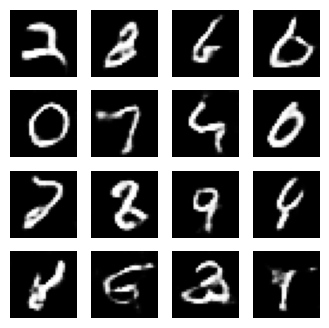

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
train(X_train, epochs)

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

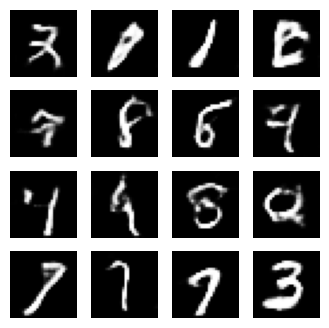

In [32]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> More implementations:

* https://github.com/robbiebarrat/art-DCGAN (based on DCGAN)
* https://github.com/tdrussell/IllustrationGAN (based on DCGAN)
* https://github.com/viuts/wgan-animefaces (based on WGAN)